# Evaluate and fit a ML model on the EC flux tower data 


## Load modules

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
import multiprocessing
from pprint import pprint
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm as lgbm
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'NEE'

In [3]:
ncpus=multiprocessing.cpu_count()
print('ncpus = '+str(ncpus))

ncpus = 16


## Prepare Data

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        td.append(xx)

In [5]:
variables = ['LAI_anom_RS',
             'kNDVI_anom_RS',
             'FPAR_RS',
             'LST_RS',
             'tree_cover_RS',
             'nontree_cover_RS',
             'nonveg_cover_RS',
             'LST-Tair_RS',
             'TWI_RS',
             'NDWI_RS',
             'rain_anom_RS',
             'rain_cml3_anom_RS',
             'rain_cml6_anom_RS',
             'rain_cml12_anom_RS',
             'srad_RS',
             'vpd_RS',
             'tavg_anom_RS',
             'SOC_RS',
             'CO2_RS'
            ]

## Modelling

In [6]:
xx = []
yy = []
for t in td:
    #t = t.drop('PFT_RS', axis=1)  
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    #df = df.filter(regex='RS') # only use remote sensing variables   
    df = df[variables]
    
    # Write out predictior variables to text file
    textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "w")
    for element in df.columns:
        textfile.write(element + ",")
    textfile.close()
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling

    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)

(2744, 19)


### Specify monotonic constraints for CO2

In [7]:
m_con= ['1' if col == 'CO2_RS' else '0' for col in x.columns]

## Feature Selection

## Test model robustness with nested K-fold cross validation

* Need to understand parameters of LightGBM better to define a sensible `param_grid`, and prevent overfitting
* If you set boosting as RF then the lightgbm algorithm behaves as random forest. According to the documentation, to use RF you must use bagging_fraction and feature_fraction smaller than 1

In [8]:
inner_cv_splits = 5

outer_cv_splits = 5

test_size = 0.20

In [11]:
# Create the parameter grid based on the results of random search 
# param_grid = {
#     'num_leaves': [7, 14, 21, 28, 31, 50, 70],
#     'boosting_type ': ['gbdt','dart'],
#     'max_depth': [-1, 3, 5, 10, 20],
#     'n_estimators': [100, 200, 300],
# }

# Create the parameter grid based on the results of random search 
param_grid = {
    # 'num_leaves': [7,21,31,50],
    #'boosting_type ': ['gbdt', 'dart'],
    # 'max_depth': [-1, 5, 10, 20],
    'n_estimators': [100,200,300],
}

In [12]:
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True,
                        random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]
i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer cv split", end='\r')
    model = LGBMRegressor(random_state=1,
                          n_jobs=ncpus,
                          monotone_constraints=m_con,
                          monotone_constraints_method='intermediate'
                          )
    
    # index training, testing, and coordinate data
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    # inner split on data within outer split
    inner_cv = KFold(n_splits=inner_cv_splits,
                     shuffle=True,
                     random_state=0)
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # Overall accuracy
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # F1 scores
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    i += 1

In [13]:
print("Mean MAE % accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE % accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

Mean MAE % accuracy: 16.71
Std dev of MAE % accuracy: 0.33


Mean RMSE: 23.49
Std dev RMSE: 0.72


Mean r2: 0.7
Std dev r2: 0.02


## Optimize model

In [14]:
param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50, 70],
    #'boosting_type ': ['gbdt', 'dart'],
    'max_depth': [-1, 3, 5, 10, 20],
    'n_estimators': [100, 200, 300, 400],
}

In [17]:
#generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=1)

#instatiate a gridsearchCV
clf = GridSearchCV(LGBMRegressor(monotone_constraints=m_con,
                                 monotone_constraints_method='intermediate'
                                 # boosting_type='rf',
                                 # bagging_freq=1, 
                                 # bagging_fraction=0.8
                                ),
                   param_grid,
                   scoring='r2',
                   #verbose=1,
                   cv=rs.split(x, y),
                   n_jobs=ncpus)


clf.fit(x, y, callbacks=None)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current 

GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7fb8d4d50660>,
             estimator=LGBMRegressor(monotone_constraints=['0', '0', '0', '0',
                                                           '0', '0', '0', '0',
                                                           '0', '0', '0', '0',
                                                           '0', '0', '0', '0',
                                                           '0', '0', '1'],
                                     monotone_constraints_method='intermediate',
                                     verbose_eval=-1),
             n_jobs=16,
             param_grid={'boosting_type ': ['gbdt', 'dart'],
                         'max_depth': [-1, 3, 5, 10, 20],
                         'n_estimators': [100, 200, 300, 400],
                         'num_leaves': [7, 14, 21, 28, 31, 50, 70]},
             scoring='r2', verbose=1)


[LightGBM] [Warning] Unknown parameter: dart
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: dart
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: dart
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: dart
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: dart
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boost

In [18]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The r2 score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting_type ': 'gbdt',
 'max_depth': -1,
 'n_estimators': 400,
 'num_leaves': 14}


The r2 score using these parameters is: 
0.71


## Fit on all data using best params


In [20]:
model = LGBMRegressor(**clf.best_params_,
                     monotone_constraints=m_con,
                     monotone_constraints_method='intermediate'
                     )

model.fit(x,y)

LGBMRegressor(boosting_type ='gbdt',
              monotone_constraints=['0', '0', '0', '0', '0', '0', '0', '0', '0',
                                    '0', '0', '0', '0', '0', '0', '0', '0', '0',
                                    '1'],
              monotone_constraints_method='intermediate', n_estimators=400,
              num_leaves=14)

## Save the model

In [21]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_LGBM_model.joblib')

['/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_NEE_LGBM_model.joblib']

## Predict on all the data

In [22]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

RMSE: 8.023


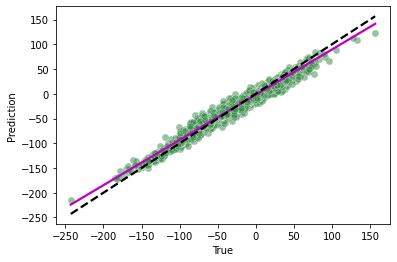

In [23]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

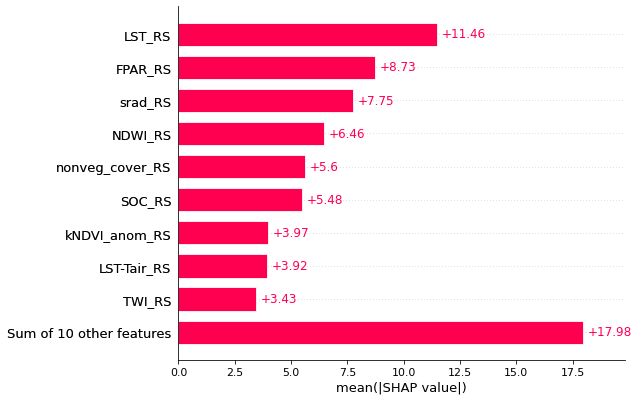

[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter

In [24]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)